# AI project team 16
Implementing the Vision Transformer (ViT) model for American Sign Language (ASL) image classification.

Dataset: Sign Language MNIST.

The code are partially based on the [ViT model](https://keras.io/examples/vision/image_classification_with_vision_transformer/) on keras.
[ViT](https://arxiv.org/abs/2010.11929)
are proposed by Alexey Dosovitskiy et al. for image classification, which applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

## Setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install -U tensorflow-addons
import tensorflow_addons as tfa

## Data loading and pre-processing

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2

basePath = ''
train = pd.read_csv(basePath + "sign_mnist_train.csv")
test = pd.read_csv(basePath + "sign_mnist_test.csv")

# generate pictures stored path
if not os.path.exists(basePath + "train_pic"):
    os.mkdir(basePath + "train_pic")
if not os.path.exists(basePath + "test_pic"):
    os.mkdir(basePath + "test_pic")

train_pic_path = basePath + "train_pic/"
test_pic_path = basePath + "test_pic/"


In [ ]:
# generate pictures
for i, row in enumerate(train.to_numpy()):
    label = row[0]
    data = row[1:]
    data = data.reshape((28, 28))
    if not os.path.exists(f'{train_pic_path}{label}'):
        os.mkdir(f'{train_pic_path}{label}')
    if not os.path.exists(f'{train_pic_path}{label}/{i}.jpeg'):
        cv2.imwrite(f'{train_pic_path}{label}/{i}.jpeg', data)

for i, row in enumerate(test.to_numpy()):
    label = row[0]
    data = row[1:]
    data = data.reshape((28, 28))
    if not os.path.exists(f'{test_pic_path}{label}'):
        os.mkdir(f'{test_pic_path}{label}')
    if not os.path.exists(f'{test_pic_path}{label}/{i}.jpeg'):
        cv2.imwrite(f'{test_pic_path}{label}/{i}.jpeg', data)

y_train = train['label'].values
x_train = train.drop(columns=['label']).to_numpy().reshape((train.shape[0], 28, 28, 1)).astype('float64')


y_test = test['label'].values
x_test = test.drop(columns=['label']).to_numpy().reshape((test.shape[0], 28, 28, 1)).astype('float64')

x_train=np.concatenate((x_train, x_train, x_train),axis=3)
x_test = np.concatenate((x_test, x_test, x_test), axis=3)
print(x_train.shape)
print(x_test.shape)
x_train = np.pad(x_train, ((0, 0), (2,2), (2,2), (0,0)), 'constant', constant_values=0.9)
x_test = np.pad(x_test, ((0, 0), (2,2), (2,2), (0,0)), 'constant', constant_values=0.9)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(27455, 28, 28, 3)
(7172, 28, 28, 3)
(27455, 32, 32, 3)
(7172, 32, 32, 3)
(27455,)
(7172,)


## Hyperparameters setting

In [ ]:
input_shape = (32, 32, 3)
num_classes = 25

num_epochs = 10
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Data augmentation

Apply data augmentation on images

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## MLP

In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Patch creation layer

In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


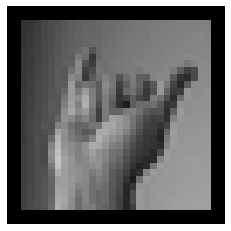

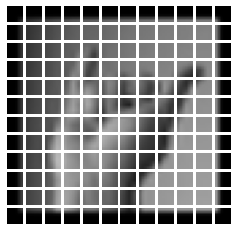

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Patch encoding layer


In [ ]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Construct the model

The ViT model that consists of multiple Transformer blocks

In [ ]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Model training

In [ ]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/10
97/97 [==============================] - 100s 878ms/step - loss: 2.8914 - accuracy: 0.1878 - top-5-accuracy: 0.5400 - val_loss: 1.5616 - val_accuracy: 0.5193 - val_top-5-accuracy: 0.9206
Epoch 2/10
97/97 [==============================] - 83s 857ms/step - loss: 1.6429 - accuracy: 0.4646 - top-5-accuracy: 0.8662 - val_loss: 0.6833 - val_accuracy: 0.7990 - val_top-5-accuracy: 0.9876
Epoch 3/10
97/97 [==============================] - 83s 858ms/step - loss: 1.0347 - accuracy: 0.6488 - top-5-accuracy: 0.9578 - val_loss: 0.3840 - val_accuracy: 0.8656 - val_top-5-accuracy: 0.9982
Epoch 4/10
97/97 [==============================] - 83s 859ms/step - loss: 0.6986 - accuracy: 0.7568 - top-5-accuracy: 0.9849 - val_loss: 0.2034 - val_accuracy: 0.9516 - val_top-5-accuracy: 0.9985
Epoch 5/10
97/97 [==============================] - 83s 858ms/step - loss: 0.5196 - accuracy: 0.8174 - top-5-accuracy: 0.9925 - val_loss: 0.1331 - val_accuracy: 0.9636 - val_top-5-accuracy: 0.9996
Epoch 6/10
97/

## Evaluation results
After 7 epochs, the ViT model achieves around 99.2% accuracy and 100% top-5 accuracy on the ASL test data. 


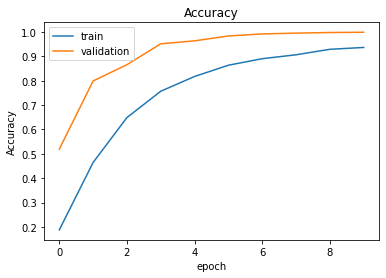

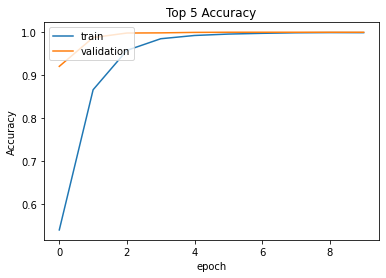

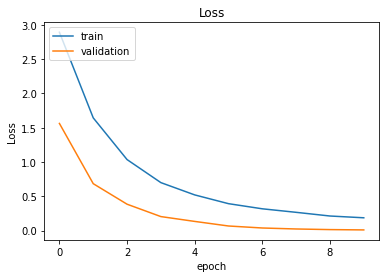

In [ ]:
def plot_model_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['top-5-accuracy'])
  plt.plot(history.history['val_top-5-accuracy'])
  plt.title('Top 5 Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()


plot_model_history(history)